# Spectrogram Reading Seminar, Lecture 5
# Semivowels a.k.a. Approximants
Mark Hasegawa-Johnson
February 14, 2018

Semivowels are [+sonorant,+continuant] sounds, like vowels.  Prosodically (long-term), they act like consonants, but segmentally (short-term), they act like vowels.  There are as many different words to describe this manner class (4: semivowel, approximant, glide, liquid) as there are phonemes in this class (4: w,j,ɻ,l), so let's walk through this maze of terminology.  
* The word "approximant" seems to be a synonym for semivowel; at least, I've never heard it used any differently.
* The words "glide" and "liquid" refer to subsets of the set "semivowels."  The glides in English are /w,j/, the liquids are /ɻ,l/.  If it seems wasteful to you that we use so many different terms to talk about such a small number of phonemes, well, you're totally right.  But anyway, here's the reason:

#### A GLIDE is just a more extreme version of a vowel.  A glide is marked by formant frequencies that are similar to the vowel, but more extreme.
* An extreme palatal vowel, /i/, becomes a palatal glide, /j/.  The F1 is even lower, and the F2 is even higher.
* An extreme labial vowel, /u/, becomes a labial glide, /w/.  Both F1 and F2 are very low.
* An extreme pharyngeal vowel, /ɑ/, becomes a pharyngeal glide, /ʕ/ (Arabic <ع>, Hebrew <ע>).  F1 is even higher, and F2 is even lower.
* It might be possible for an extreme velar vowel, /ʌ/, to become a velar glide /ɰ/... well, this is a weird one, because the formant frequencies are not extreme at all.  In fact, I've only ever seen /ɰ/ as a softening of /ɡ/, as in the name "Erdogan".

####  A LIQUID is made with a side branch under the tongue.  The side branch introduces a zero into the vocal tract transfer function, which is used to drive F3 either very high or very low.
* An /ɻ/ (an American English "r") is a semivowel with a very low F3.  Any time you see F3<2000 Hz, you know that there's an /ɻ/.
* An /l/ is a semivowel with a very high F3.  Any time you see F3>3000 Hz, you know that there's an /l/.  Often, this shows up as a sort of discontinuity where F3 seems to vanish for a while, while the tongue tip is closed. 

Here's a figure to describe it:
<img src="glidesfig.png" />

In [39]:
import urllib.request as request
import io
import soundfile as sf
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib inline
import spectrogram
import math

In [40]:
consonant_pathnames = {
        'w' : 'f/f2/Voiced_labio-velar_approximant',
        'j' : 'e/e8/Palatal_approximant',
        'ɻ' : '3/33/Postalveolar_approximant',
        'l' : 'b/bc/Alveolar_lateral_approximant',
        'ʕ' : 'c/cd/Voiced_pharyngeal_fricative',
        'ɰ':'5/5c/Voiced_velar_approximant'
        }
    
consonant_waves = {}

for c_ipa,c_pathname in consonant_pathnames.items():
    c_url = 'https://upload.wikimedia.org/wikipedia/commons/{}.ogg'.format(c_pathname)
    try:
        req = request.urlopen(c_url)
    except request.HTTPError:
        print('Unable to download {}'.format(c_url))
    else:
        c_wav,c_fs = sf.read(io.BytesIO(req.read()))
        c_filename = c_ipa + '.wav'
        sf.write(c_filename,c_wav,c_fs)
        consonant_waves[c_ipa] = c_wav

print('Donwnloaded these phones: {}'.format(consonant_waves.keys()))

Donwnloaded these phones: dict_keys(['w', 'j', 'ɻ', 'l', 'ʕ', 'ɰ'])


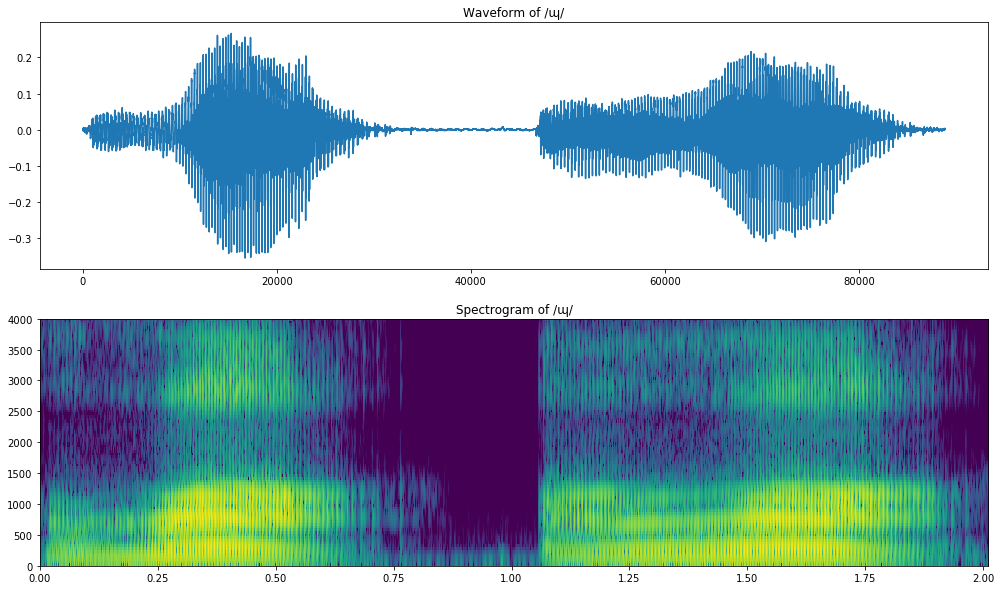

In [41]:
consonant = 'ɰ'
(S,Ext)=sg.sgram(consonant_waves[consonant], int(0.001*c_fs), int(0.006*c_fs), 1024, c_fs, 4000)
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(consonant_waves[consonant])
plt.title('Waveform of /{}/'.format(consonant))
plt.subplot(212)
plt.imshow(S,origin='lower',extent=Ext,aspect='auto')
plt.title('Spectrogram of /{}/'.format(consonant))

### Digression: pre-emphasis

That spectrogram has a huge voicebar.  We had the same problem last time.  I finally figured out what I was missing, that should get rid of the overly huge voicebar: pre-emphasis.

Pre-emphasis is a simple one-tap high-pass filter, a.k.a. a differentiator, or more correctly, a differencer.  Those are fancy words meaning that we compute the difference between each sample and the one before it:
$$y[n] = x[n] - \alpha x[n-1]$$
where $\alpha$, the pre-emphasis factor, can be set to something like 0.95, or 0.97, or maybe even 0.99.  Even 1.0 might work just fine.  Tweak it until the spectrogram looks right to you.

Since last week, I've added the following pre-emphasis function to the newly downloadable file spectrogram.py, so you can get it if you download https://courses.engr.illinois.edu/ece590sip/sp2018/spectrogram.py.

In [42]:
def preemphasize(x,alpha):
    y = np.zeros(len(x))
    y[0] = x[0]
    for n in range(1,len(x)):
        y[n] = x[n] - alpha*x[n-1]
    return(y)

In [43]:
def sgram(x,frame_skip,frame_length,fft_length, fs, max_freq, alpha=0):
    '''USAGE:
    import sgram
    (x_sgram,x_extent) = sgram.sgram(x, frame_skip, frame_length, fft_length, fs, max_freq)
    plt.figure(figsize=(14,4))
    plt.imshow(x_sgram,origin='lower',extent=x_extent,aspect='auto')
    '''
    if len(x.shape) > 1:  # If x is stereo, sum over the channels
        x = np.sum(x,axis=1)
    y = preemphasize(x,alpha)
    frames = enframe(y,frame_skip,frame_length)
    (spectra, freq_axis) = stft(frames, fft_length, fs)
    sgram = stft2level(spectra, int(max_freq*fft_length/fs))
    max_time = len(frames)*frame_skip/fs
    return(np.transpose(np.array(sgram)), (0,max_time,0,max_freq))


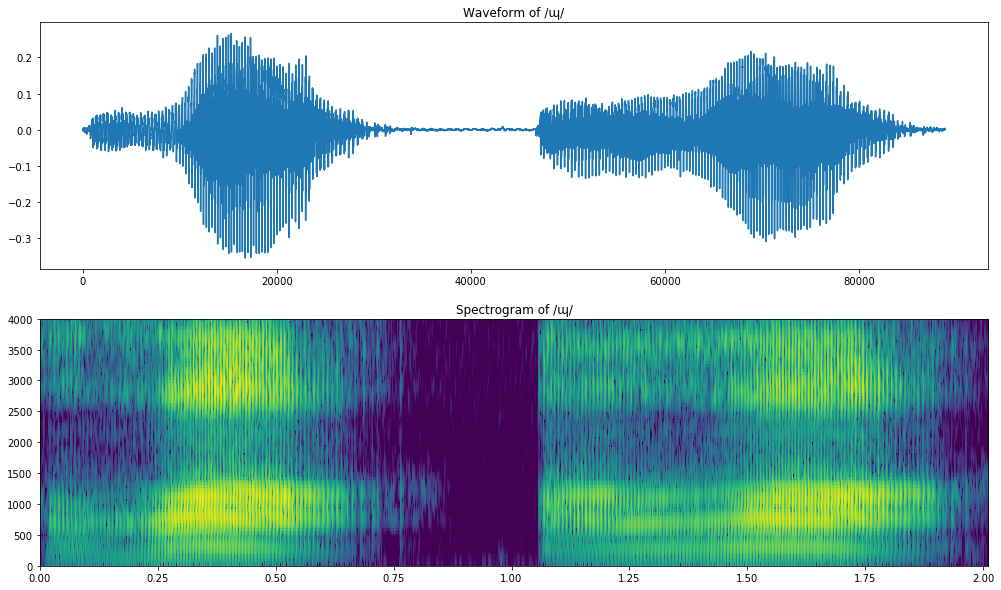

In [50]:
import spectrogram as sg
consonant = 'ɰ'
(S,Ext)=sg.sgram(consonant_waves[consonant], int(0.001*c_fs), int(0.006*c_fs), 1024, c_fs, 4000, 0.99)
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(consonant_waves[consonant])
plt.title('Waveform of /{}/'.format(consonant))
plt.subplot(212)
plt.imshow(S,origin='lower',extent=Ext,aspect='auto')
plt.title('Spectrogram of /{}/'.format(consonant))

## A good source of data from lots of languages: SBS

Let's try spectrogram reading from an interesting source with data in lots of languages: the Australian special broadcasting service, https://www.sbs.com.au/radio/yourlanguage

I have never found any other service making podcasts available in so many languages.  Youtube does, but youtube specifically forbids direct download of their files, which means youtube is useless to science.  SBS tries to encourage you to listen on their site, but they have not yet completely forbidden direct download; I hope they won't.

There is no simple button to download a file, but if you click on a file to play it, then a complex HTTP Get request will show up at the top.  In that Get request, there is a field called fileuri.  If you cut and paste that fileuri into another window, you will still get a streaming interface, but now there is a download button available.    As of the time of this writing, you can download a sample file from http://media.sbs.com.au/ondemand/audio/Tuesday_ONDemand_ARABIC24_06_00.mp3

The file is still in mp3.   I haven't been able to find a python package I like that reads MP3 audio, so I used the following steps:
* download the mp3 to my working directory
* sudo apt-get install mpg123
* mpg123 -w Thursday_ONDemand_ARABIC24_06_00.wav Thursday_ONDemand_ARABIC24_06_00.mp3
* use the code below to read in part of the WAV file (if I try to read all three hours, I get a memory error)

In [68]:
filename = 'Thursday_ONDemand_ARABIC24_06_00.wav'
x_wav_stereo,x_fs = sf.read(filename,1323000) # Read only the first 10 seconds (30*44100=1323000)
x_wav_mono = np.sum(x_wav_stereo,axis=1)

print('Read audio from {}, {} samples at {} samples/second'.format(filename,len(x_wav_mono),x_fs))


Read audio from Thursday_ONDemand_ARABIC24_06_00.wav, 1323000 samples at 44100 samples/second


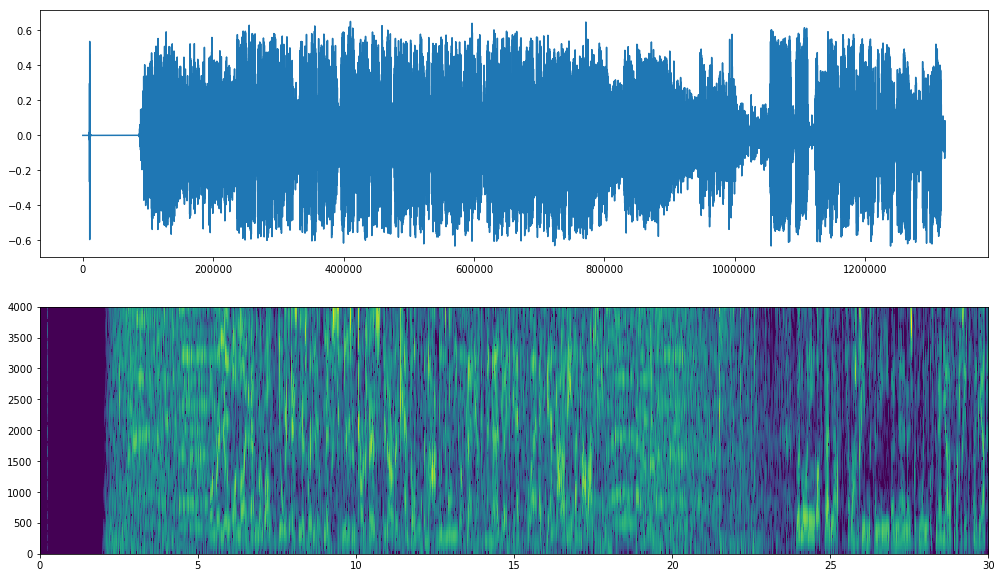

In [70]:
(x_sgram,x_extent)=sg.sgram(x_wav_mono, int(0.006*x_fs), int(0.006*x_fs), 1024, x_fs, 4000, 0.99)
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(x_wav_mono)
plt.subplot(212)
plt.imshow(x_sgram,origin='lower',extent=x_extent,aspect='auto')

Looks like there's silence from 0 to 2 seconds, then music from about 2 to 5 seconds, then speech from about 5 to 17 seconds, then music again from 17 to 24 seconds, then speech from 24 seconds onward.  
* The first long speech segment is the bumper, which is half in English and half in Arabic.
* The news caster begins at 24 seconds, but she begins in English, and then switches to Arabic.
* In order to get a speech segment in Arabic, let's read from 25 seconds onward.
* It's not really possible to read the spectrogram of a segment with more than 2 seconds in it.
* Let's try reading the segment from 25.0 to 27.0 seconds. 

In [72]:
x_speech = x_wav_mono[int(25*x_fs):int(27*x_fs)]
sf.write('Thursday_speech.wav',x_speech,x_fs)

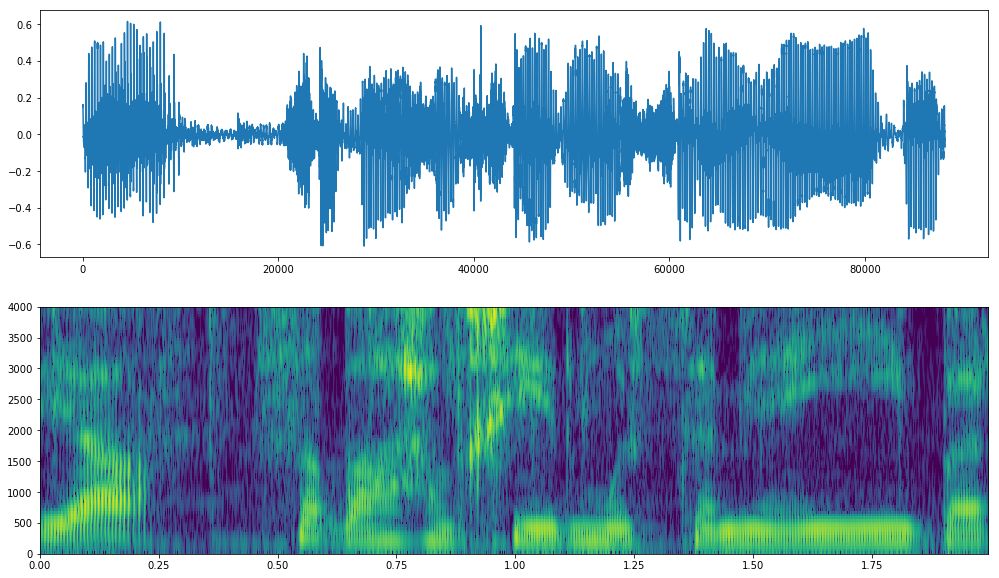

In [73]:
(x_sgram,x_extent)=sg.sgram(x_speech, int(0.001*x_fs), int(0.006*x_fs), 1024, x_fs, 4000, 0.97)
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(x_speech)
plt.subplot(212)
plt.imshow(x_sgram,origin='lower',extent=x_extent,aspect='auto')

We don't really have enough knowledge, yet, to try to read this from scratch.  But if you listen to the audio, you should be able to find the semivowels.
* Right at the start of this segment, there's a /j/.  That's actually the last syllable of her English intro, "Good morning Australia".
* This speaker has a really high F3 all the way through, but notice that it goes a little higher than normal from 0.8 to 0.9 seconds, during the syllable "al".
* Then F3 drops, as low as it ever goes, during the syllable "xEr", from 1.0 to 1.1 seconds.  It only drops to about 2100Hz, but that's pretty low for this speaker.
* From 1.1 to 1.25 seconds, there's an /u/, which is basically the vowel version of /w/... it has a very weak F2, so weak that it only shows up after about the 1.15 second mark.  It's frequency is 1000Hz, clearly saying that this is a back vowel; the low F1 means it's either /u/ or /o/.
* Finally, there's a nice prolonged /j/ from 1.6 to 1.8 seconds.
